Импорт библиотек

In [1]:
import urllib.request
import tarfile
import os

import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from matplotlib.cm import jet

Загрузка датасета

In [ ]:
url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
file_name = "images.tar.gz"

urllib.request.urlretrieve(url, file_name)

with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()

os.remove(file_name)

# Предобработка данных

In [2]:
folder_path = 'images/'

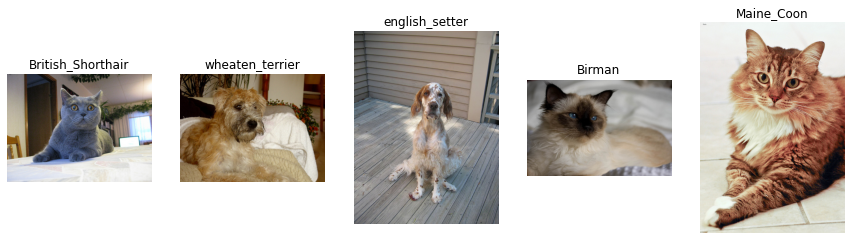

In [3]:
def visualize_random_pet_images(folder_path, num_images=5):
    plt.figure(figsize=(15, 8))

    pet_images = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    selected_images = random.sample(pet_images, num_images)

    for i, image in enumerate(selected_images, start=1):
        image_path = os.path.join(folder_path, image)
        breed = '_'.join(image.split('_')[:-1])

        img = mpimg.imread(image_path)
        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(breed)
        plt.axis('off')

    plt.show()

visualize_random_pet_images(folder_path, num_images=5)

In [4]:
def count_images(folder_path):
    total_count = 0
    breed_counts = {}

    pet_images = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    for image in pet_images:
        breed = '_'.join(image.split('_')[:-1])
        breed_counts[breed] = breed_counts.get(breed, 0) + 1
        total_count += 1

    return total_count, breed_counts

total_count, breed_counts = count_images(folder_path)

print("Общее количество фотографий:", total_count)
print("Количество фотографий для каждой породы:")
for breed, count in breed_counts.items():
    print(f"{breed}: {count}")

Общее количество фотографий: 7390
Количество фотографий для каждой породы:
Abyssinian: 200
american_bulldog: 200
american_pit_bull_terrier: 200
basset_hound: 200
beagle: 200
Bengal: 200
Birman: 200
Bombay: 200
boxer: 200
British_Shorthair: 200
chihuahua: 200
Egyptian_Mau: 200
english_cocker_spaniel: 200
english_setter: 200
german_shorthaired: 200
great_pyrenees: 200
havanese: 200
japanese_chin: 200
keeshond: 200
leonberger: 200
Maine_Coon: 200
miniature_pinscher: 200
newfoundland: 200
Persian: 200
pomeranian: 200
pug: 200
Ragdoll: 200
Russian_Blue: 200
saint_bernard: 200
samoyed: 200
scottish_terrier: 199
shiba_inu: 200
Siamese: 200
Sphynx: 200
staffordshire_bull_terrier: 191
wheaten_terrier: 200
yorkshire_terrier: 200


In [6]:
def create_dataframe(folder_path):
    image_paths = []
    labels = []

    pet_images = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    for image in pet_images:
        breed = '_'.join(image.split('_')[:-1])
        image_path = os.path.join(folder_path, image)
        image_paths.append(image_path)
        labels.append(breed)

    df = pd.DataFrame({'Path': image_paths, 'Label': labels})
    return df


df = create_dataframe(folder_path)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)
train_df.sample(5)

,Path,Label
347,images/american_bulldog_50.jpg,american_bulldog
2828,images/german_shorthaired_124.jpg,german_shorthaired
403,images/american_pit_bull_terrier_101.jpg,american_pit_bull_terrier
3014,images/great_pyrenees_111.jpg,great_pyrenees
7163,images/wheaten_terrier_75.jpg,wheaten_terrier


In [8]:
image_size = 224
image_shape = (image_size, image_size)
batch_size = 32

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='Label',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Label',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

Found 5912 validated image filenames belonging to 37 classes.
Found 1478 validated image filenames belonging to 37 classes.


# Определение моделей и их обучение

In [11]:
num_classes = df['Label'].value_counts().count()

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
resnet101_base = ResNet101(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [12]:
def change_model(model_base, num_classes, dropout_rate=0.5):

    for layer in model_base.layers:
        layer.trainable = False

    x = model_base.output
    x = Flatten()(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=model_base.input, outputs=predictions)

    return model

vgg16_model = change_model(vgg16_base, num_classes)
vgg19_model = change_model(vgg19_base, num_classes)
resnet50_model = change_model(resnet50_base, num_classes)
resnet101_model = change_model(resnet101_base, num_classes)

vgg16

In [13]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

Epoch 1/20
185/185 [==============================] - 89s 464ms/step - loss: 3.0017 - accuracy: 0.2258 - val_loss: 2.6605 - val_accuracy: 0.3139
Epoch 2/20
185/185 [==============================] - 83s 450ms/step - loss: 2.0408 - accuracy: 0.4132 - val_loss: 1.5656 - val_accuracy: 0.5101
Epoch 3/20
185/185 [==============================] - 84s 452ms/step - loss: 1.7902 - accuracy: 0.4734 - val_loss: 1.4510 - val_accuracy: 0.5602
Epoch 4/20
185/185 [==============================] - 84s 451ms/step - loss: 1.6524 - accuracy: 0.5061 - val_loss: 1.5323 - val_accuracy: 0.5507
Epoch 5/20
185/185 [==============================] - 83s 447ms/step - loss: 1.5780 - accuracy: 0.5348 - val_loss: 1.2863 - val_accuracy: 0.6103
Epoch 6/20
185/185 [==============================] - 83s 448ms/step - loss: 1.4845 - accuracy: 0.5479 - val_loss: 1.3005 - val_accuracy: 0.6116
Epoch 7/20
185/185 [==============================] - 83s 447ms/step - loss: 1.4417 - accuracy: 0.5631 - val_loss: 1.3801 - val_ac

vgg19

In [15]:
vgg19_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [16]:
vgg19_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history_vgg19 = vgg19_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

Epoch 1/20
185/185 [==============================] - 84s 449ms/step - loss: 3.1076 - accuracy: 0.2126 - val_loss: 3.5166 - val_accuracy: 0.2673
Epoch 2/20
185/185 [==============================] - 82s 444ms/step - loss: 2.2739 - accuracy: 0.3525 - val_loss: 2.1853 - val_accuracy: 0.4141
Epoch 3/20
185/185 [==============================] - 82s 443ms/step - loss: 1.9913 - accuracy: 0.4283 - val_loss: 1.6054 - val_accuracy: 0.5162
Epoch 4/20
185/185 [==============================] - 82s 443ms/step - loss: 1.8518 - accuracy: 0.4489 - val_loss: 2.0229 - val_accuracy: 0.4438
Epoch 5/20
185/185 [==============================] - 82s 443ms/step - loss: 1.7373 - accuracy: 0.4775 - val_loss: 1.4687 - val_accuracy: 0.5562
Epoch 6/20
185/185 [==============================] - 82s 443ms/step - loss: 1.6935 - accuracy: 0.4866 - val_loss: 1.9014 - val_accuracy: 0.4790
Epoch 7/20
185/185 [==============================] - 82s 444ms/step - loss: 1.6245 - accuracy: 0.5132 - val_loss: 3.8437 - val_ac

resnet50

In [18]:
resnet50_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [19]:
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history_resnet50 = resnet50_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

Epoch 1/20
185/185 [==============================] - 88s 449ms/step - loss: 3.8695 - accuracy: 0.0553 - val_loss: 13.4592 - val_accuracy: 0.0372
Epoch 2/20
185/185 [==============================] - 82s 440ms/step - loss: 3.6269 - accuracy: 0.0788 - val_loss: 35.4062 - val_accuracy: 0.0271
Epoch 3/20
185/185 [==============================] - 82s 441ms/step - loss: 3.4923 - accuracy: 0.0934 - val_loss: 5.4392 - val_accuracy: 0.0622
Epoch 4/20
185/185 [==============================] - 82s 442ms/step - loss: 3.4514 - accuracy: 0.0988 - val_loss: 18.4105 - val_accuracy: 0.0521
Epoch 5/20
185/185 [==============================] - 82s 440ms/step - loss: 3.3610 - accuracy: 0.1157 - val_loss: 4.4269 - val_accuracy: 0.0737
Epoch 6/20
185/185 [==============================] - 81s 438ms/step - loss: 3.3217 - accuracy: 0.1233 - val_loss: 9.6919 - val_accuracy: 0.0562
Epoch 7/20
185/185 [==============================] - 81s 440ms/step - loss: 3.2769 - accuracy: 0.1313 - val_loss: 3.5843 - val

In [21]:
resnet101_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [22]:
resnet101_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history_resnet101 = resnet101_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

Epoch 1/20
185/185 [==============================] - 95s 475ms/step - loss: 3.8652 - accuracy: 0.0582 - val_loss: 6.9468 - val_accuracy: 0.0392
Epoch 2/20
185/185 [==============================] - 86s 464ms/step - loss: 3.6365 - accuracy: 0.0732 - val_loss: 7.7881 - val_accuracy: 0.0521
Epoch 3/20
185/185 [==============================] - 87s 467ms/step - loss: 3.5510 - accuracy: 0.0824 - val_loss: 5.5038 - val_accuracy: 0.0453
Epoch 4/20
185/185 [==============================] - 86s 465ms/step - loss: 3.4863 - accuracy: 0.0886 - val_loss: 4.3909 - val_accuracy: 0.0778
Epoch 5/20
185/185 [==============================] - 86s 465ms/step - loss: 3.4260 - accuracy: 0.1010 - val_loss: 13.9864 - val_accuracy: 0.0386
Epoch 6/20
185/185 [==============================] - 86s 465ms/step - loss: 3.3873 - accuracy: 0.0990 - val_loss: 71.7660 - val_accuracy: 0.0271
Epoch 7/20
185/185 [==============================] - 86s 464ms/step - loss: 3.3527 - accuracy: 0.1023 - val_loss: 6.0694 - val_

# Оценка качества моделей

In [27]:
loss, accuracy = vgg16_model.evaluate(validation_generator)
print("Loss vgg16:", loss)
print("Accuracy vgg16:", accuracy)

loss2, accuracy2 = vgg19_model.evaluate(validation_generator)
print("Loss vgg19:", loss2)
print("Accuracy vgg19:", accuracy2)

loss3, accuracy3 = resnet50_model.evaluate(validation_generator)
print("Loss resnet50:", loss3)
print("Accuracy resnet50:", accuracy3)

loss4, accuracy4 = resnet101_model.evaluate(validation_generator)
print("Loss resnet101:", loss4)
print("Accuracy resnet101:", accuracy4)

47/47 [==============================] - 8s 164ms/step - loss: 1.2259 - accuracy: 0.6313
Loss vgg16: 1.2258864641189575
Accuracy vgg16: 0.6312584280967712
47/47 [==============================] - 9s 193ms/step - loss: 1.3829 - accuracy: 0.5900
Loss vgg19: 1.3829425573349
Accuracy vgg19: 0.5899864435195923
47/47 [==============================] - 8s 167ms/step - loss: 3.6927 - accuracy: 0.1022
Loss resnet50: 3.692744493484497
Accuracy resnet50: 0.102165088057518
47/47 [==============================] - 13s 269ms/step - loss: 4.0750 - accuracy: 0.0839
Loss resnet101: 4.0749616622924805
Accuracy resnet101: 0.08389715850353241


In [24]:
train_loss_vgg16 = history_vgg16.history['loss']
test_loss_vgg16 = history_vgg16.history['val_loss']
train_acc_vgg16 = history_vgg16.history['accuracy']
test_acc_vgg16 = history_vgg16.history['val_accuracy']

train_loss_vgg19 = history_vgg19.history['loss']
test_loss_vgg19 = history_vgg19.history['val_loss']
train_acc_vgg19 = history_vgg19.history['accuracy']
test_acc_vgg19 = history_vgg19.history['val_accuracy']

train_loss_resnet50 = history_resnet50.history['loss']
test_loss_resnet50 = history_resnet50.history['val_loss']
train_acc_resnet50 = history_resnet50.history['accuracy']
test_acc_resnet50 = history_resnet50.history['val_accuracy']

train_loss_resnet101 = history_resnet101.history['loss']
test_loss_resnet101 = history_resnet101.history['val_loss']
train_acc_resnet101 = history_resnet101.history['accuracy']
test_acc_resnet101 = history_resnet101.history['val_accuracy']


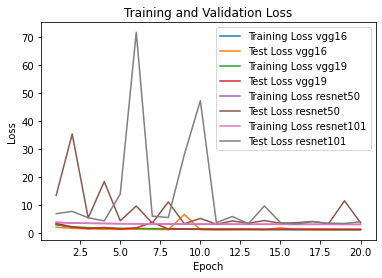

In [25]:
plt.plot(range(1, len(train_loss_vgg16) + 1), train_loss_vgg16, label='Training Loss vgg16')
plt.plot(range(1, len(test_loss_vgg16) + 1), test_loss_vgg16, label='Test Loss vgg16')

plt.plot(range(1, len(train_loss_vgg19) + 1), train_loss_vgg19, label='Training Loss vgg19')
plt.plot(range(1, len(test_loss_vgg19) + 1), test_loss_vgg19, label='Test Loss vgg19')

plt.plot(range(1, len(train_loss_resnet50) + 1), train_loss_resnet50, label='Training Loss resnet50')
plt.plot(range(1, len(test_loss_resnet50) + 1), test_loss_resnet50, label='Test Loss resnet50')

plt.plot(range(1, len(train_loss_resnet101) + 1), train_loss_resnet101, label='Training Loss resnet101')
plt.plot(range(1, len(test_loss_resnet101) + 1), test_loss_resnet101, label='Test Loss resnet101')


plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

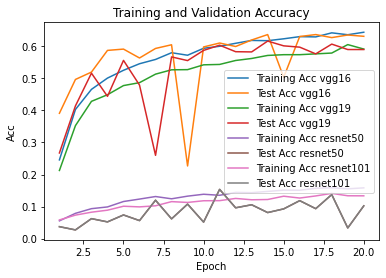

In [26]:
plt.plot(range(1, len(train_acc_vgg16) + 1), train_acc_vgg16, label='Training Acc vgg16')
plt.plot(range(1, len(test_acc_vgg16) + 1), test_acc_vgg16, label='Test Acc vgg16')

plt.plot(range(1, len(train_acc_vgg19) + 1), train_acc_vgg19, label='Training Acc vgg19')
plt.plot(range(1, len(test_acc_vgg19) + 1), test_acc_vgg19, label='Test Acc vgg19')

plt.plot(range(1, len(train_acc_resnet50) + 1), train_acc_resnet50, label='Training Acc resnet50')
plt.plot(range(1, len(test_acc_resnet50) + 1), test_acc_resnet50, label='Test Acc resnet50')

plt.plot(range(1, len(train_acc_resnet101) + 1), train_acc_resnet101, label='Training Acc resnet101')
plt.plot(range(1, len(test_acc_resnet101) + 1), test_acc_resnet50, label='Test Acc resnet101')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

In [17]:
y_pred = []
y_pred_proba = []
y_true = []

for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]

    y_pred_proba_batch = vgg16_model.predict(x_batch)
    y_pred_batch = np.argmax(y_pred_proba_batch, axis=1)

    y_pred.extend(y_pred_batch)
    y_pred_proba.extend(y_pred_proba_batch)
    y_true.extend(np.argmax(y_batch, axis=1))

y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)
y_true = np.array(y_true)


print("Предсказанные классы:", y_pred)
print("Правильные классы:", y_true)

Предсказанные классы: [ 9  3  2 ... 21 31 27]
Правильные классы: [ 9  3  2 ... 21 31 27]


In [18]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')

top3_accuracy = top_k_accuracy_score(y_true, y_pred_proba, k=3)
print(f'Top-3 Accuracy: {top3_accuracy}')

top5_accuracy = top_k_accuracy_score(y_true, y_pred_proba, k=5)
print(f'Top-5 Accuracy: {top5_accuracy}')

Accuracy: 0.6407307171853857
Top-3 Accuracy: 0.8640054127198917
Top-5 Accuracy: 0.9235453315290933


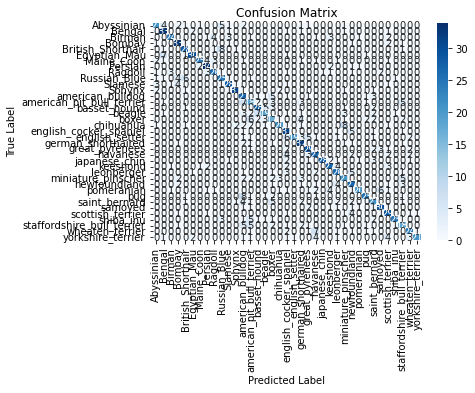

In [19]:
conf_matrix = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Визуализация зон интереса

In [20]:
def gradcam(model, img_array, class_index, layer_name):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_output, pooled_grads), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

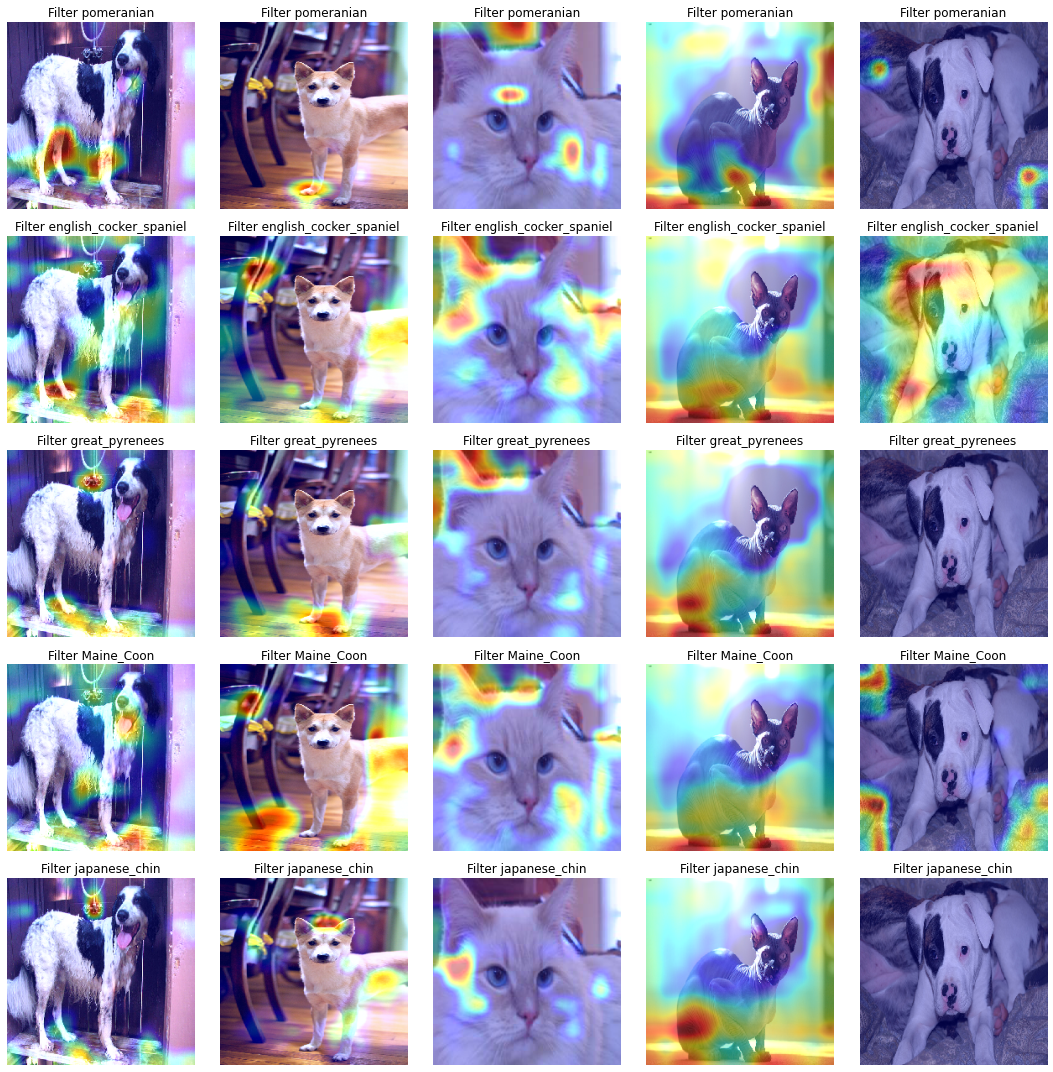

In [35]:
X_test, _ = next(validation_generator)
img_indices = np.random.randint(0, len(X_test), size=5)
class_indices = np.random.randint(0, num_classes, size=5)
layer_name = 'block5_conv3'

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i, img_index in enumerate(img_indices):
    img_array = np.expand_dims(X_test[img_index], axis=0)
    for j, class_index in enumerate(class_indices):
        class_name = list(breed_counts.keys())[class_index]
        heatmap = gradcam(vgg16_model, img_array, class_index, layer_name)
        img = img_array[0]

        heatmap = Image.fromarray((heatmap * 255).astype(np.uint8))
        heatmap = heatmap.resize((img.shape[1], img.shape[0]))
        heatmap = np.array(heatmap) / 255.0

        heatmap = jet(heatmap)
        heatmap = heatmap[:, :, :3]
        superimposed_img = heatmap * 0.5  + img

        axes[j, i].imshow(superimposed_img)
        axes[j, i].set_title(f'Filter {class_name}')
        axes[j, i].axis('off')


plt.tight_layout()
plt.show()